In [1]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from p_tqdm import p_map

/work/xinchenhe_umass_edu/.conda/envs/laketemp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# each model is trained for 10 times for each seed
ensemble_num = 10

In [3]:
# lake list
cci_lake_list = pd.read_csv("../data/cci_lakes_hydrolake_depth.csv")["CCI ID"].to_numpy()

# data paths to simulated water temperature
a2w_full_sim_dir = "/nas/cee-hydro/laketemp_bias/simulations/a2w_full_sim"
a2w_cloud_sim_dir = "/nas/cee-hydro/laketemp_bias/simulations/a2w_cloud_sim"
lstm_full_sim_dir = "/nas/cee-hydro/laketemp_bias/simulations/lstm_full_sim"
lstm_cloud_sim_dir = "/nas/cee-hydro/laketemp_bias/simulations/lstm_cloud_sim"

# observations
df_tw = pd.read_csv("/nas/cee-hydro/laketemp_bias/era5land/water_temp.csv", index_col=0, 
                    parse_dates=True).loc[:, cci_lake_list.astype(str)]
df_tw_cloud = pd.read_csv("/nas/cee-hydro/laketemp_bias/era5land/water_temp_cloud.csv", index_col=0, 
                    parse_dates=True).loc[:, cci_lake_list.astype(str)]

In [4]:
train_period = pd.date_range("2003-01-01", "2017-12-31")
val_period = pd.date_range("2018-01-01", "2023-12-31")
total_period = pd.date_range("2003-01-01", "2023-12-31")

In [5]:
def calc_rmse(obs, sim):
    '''RMSE'''
    if len(obs) != len(sim):
        raise ValueError("Arrays must have the same size.")

    mask = ~np.isnan(obs)
    obs = obs[mask]
    sim = sim[mask]
        
    # Calculate the rmse value
    rmse_val = np.sqrt(np.mean((obs-sim)**2))
    return rmse_val

def calc_error(obs, sim):
    '''Mean error or statistical bias'''
    if len(obs) != len(sim):
        raise ValueError("Arrays must have the same size.")

    mask = ~np.isnan(obs)
    obs = obs[mask]
    sim = sim[mask]
        
    # Calculate the rmse value
    me = np.mean(sim - obs)
    return me
    
def calc_nse(obs, sim):
    
    if len(obs) != len(sim):
        raise ValueError("Arrays must have the same size.")
    
    # drop nan for both obs and sim
    mask = ~np.isnan(obs)
    sim = sim[mask]
    obs = obs[mask]
    
    # denominator of the fraction term
    denominator = np.sum((obs-np.mean(obs))**2)
    
    # this would lead to a division by zero error and nse is defined as -inf
    if denominator == 0:
        return np.NaN
    
    # numerator of the fraction term
    numerator = np.sum((sim-obs)**2)
    
    # calculate the NSE
    nse_val = 1 - numerator/denominator
    
    return nse_val

**Note: all simulations are compareed with daily continous observations**

# Air2water

In [6]:
def evaluate_a2w(lake_id, cloud = False):
    a2w_metric = pd.DataFrame([], index = [lake_id], columns = ["cal_rmse", "val_rmse", "cal_nse", "val_nse"])
    
    if cloud == True:
        sim_df = pd.read_csv(f"{a2w_cloud_sim_dir}/{lake_id}.csv", index_col=0, parse_dates=True)
    else:
        sim_df = pd.read_csv(f"{a2w_full_sim_dir}/{lake_id}.csv", index_col=0, parse_dates=True)
        
    # load observation
    obs_df = df_tw.loc[:, [str(lake_id)]]
    
    # calculate nse for train and val
    a2w_metric.loc[lake_id, "cal_nse"] = np.mean([calc_nse(obs_df.loc[train_period].to_numpy().ravel(), 
                                                           sim_df.loc[train_period].iloc[:, i].to_numpy().ravel()
                                                          ) for i in range(ensemble_num)])
    a2w_metric.loc[lake_id, "val_nse"] = np.mean([calc_nse(obs_df.loc[val_period].to_numpy().ravel(), 
                                                           sim_df.loc[val_period].iloc[:, i].to_numpy().ravel()
                                                          ) for i in range(ensemble_num)])
    
    # calculate mean error for train and val
    a2w_metric.loc[lake_id, "cal_me"] = np.mean([calc_error(obs_df.loc[val_period].to_numpy().ravel(), 
                                                           sim_df.loc[val_period].iloc[:, i].to_numpy().ravel()
                                                          ) for i in range(ensemble_num)])
    a2w_metric.loc[lake_id, "val_me"] = np.mean([calc_error(obs_df.loc[val_period].to_numpy().ravel(), 
                                                           sim_df.loc[val_period].iloc[:, i].to_numpy().ravel()
                                                          ) for i in range(ensemble_num)])
    
    # calculate mse for train and val
    a2w_metric.loc[lake_id, "cal_rmse"] = np.mean([calc_rmse(obs_df.loc[train_period].to_numpy().ravel(), 
                                                             sim_df.loc[train_period].iloc[:, i].to_numpy().ravel()
                                                            ) for i in range(ensemble_num)])
    a2w_metric.loc[lake_id, "val_rmse"] = np.mean([calc_rmse(obs_df.loc[val_period].to_numpy().ravel(), 
                                                             sim_df.loc[val_period].iloc[:, i].to_numpy().ravel()
                                                            ) for i in range(ensemble_num)])
    return a2w_metric

In [7]:
# def evaluate_a2w_cloud(lake_id):
#     a2w_metric = pd.DataFrame([], index = [lake_id], columns = ["cal_rmse", "val_rmse", "cal_nse", "val_nse"])
#     # sim_df = pd.read_csv(f"{a2w_full_sim_dir}/{lake_id}.csv", index_col=0, parse_dates=True)
#     sim_df_cloud = pd.read_csv(f"{a2w_cloud_sim_dir}/{lake_id}.csv", index_col=0, parse_dates=True)
#     # load observation
#     # obs_df = df_tw.loc[:, [str(lake_id)]]
#     obs_df_cloud = df_tw_cloud.loc[:, [str(lake_id)]]
#     # calculate nse for train and val
#     a2w_metric.loc[lake_id, "cal_nse"] = np.mean([calc_nse(obs_df_cloud.loc[train_period].to_numpy().ravel(), 
#                                                            sim_df_cloud.loc[train_period].iloc[:, i].to_numpy().ravel()
#                                                           ) for i in range(ensemble_num)])
#     a2w_metric.loc[lake_id, "val_nse"] = np.mean([calc_nse(obs_df_cloud.loc[val_period].to_numpy().ravel(), 
#                                                            sim_df_cloud.loc[val_period].iloc[:, i].to_numpy().ravel()
#                                                           ) for i in range(ensemble_num)])
#     # calculate mse for train and val
#     a2w_metric.loc[lake_id, "cal_rmse"] = np.mean([calc_rmse(obs_df_cloud.loc[train_period].to_numpy().ravel(), 
#                                                              sim_df_cloud.loc[train_period].iloc[:, i].to_numpy().ravel()
#                                                             ) for i in range(ensemble_num)])
#     a2w_metric.loc[lake_id, "val_rmse"] = np.mean([calc_rmse(obs_df_cloud.loc[val_period].to_numpy().ravel(), 
#                                                              sim_df_cloud.loc[val_period].iloc[:, i].to_numpy().ravel()
#                                                             ) for i in range(ensemble_num)])
#     return a2w_metric

In [8]:
a2w_metric_df = pd.concat(p_map(lambda x: evaluate_a2w(x, cloud = False), cci_lake_list))
a2w_metric_df_cloud = pd.concat(p_map(lambda x: evaluate_a2w(x, cloud = True), cci_lake_list))

100%|██████████| 2016/2016 [00:34<00:00, 58.49it/s]


# LSTM

In [9]:
def evaluate_lstm(lake_id, cloud = False):
    lstm_metric = pd.DataFrame([], index = [lake_id], columns = ["cal_rmse", "val_rmse", "cal_me", "val_me", "cal_nse", "val_nse"])
    
    if cloud == True:
        sim_df = pd.read_csv(f"{lstm_cloud_sim_dir}/{lake_id}.csv", index_col=0, parse_dates=True)
    else:
        sim_df = pd.read_csv(f"{lstm_full_sim_dir}/{lake_id}.csv", index_col=0, parse_dates=True)
    
    # load observation
    obs_df = df_tw.loc[:, [str(lake_id)]]
    
    # calculate nse for train and val
    lstm_metric.loc[lake_id, "cal_nse"] = np.mean([calc_nse(obs_df.loc[train_period].to_numpy().ravel(), 
                                                           sim_df.loc[train_period].iloc[:, i].to_numpy().ravel()
                                                          ) for i in range(ensemble_num)])
    lstm_metric.loc[lake_id, "val_nse"] = np.mean([calc_nse(obs_df.loc[val_period].to_numpy().ravel(), 
                                                           sim_df.loc[val_period].iloc[:, i].to_numpy().ravel()
                                                          ) for i in range(ensemble_num)])
    # calculate mean error for train and val
    lstm_metric.loc[lake_id, "cal_me"] = np.mean([calc_error(obs_df.loc[val_period].to_numpy().ravel(), 
                                                           sim_df.loc[val_period].iloc[:, i].to_numpy().ravel()
                                                          ) for i in range(ensemble_num)])
    lstm_metric.loc[lake_id, "val_me"] = np.mean([calc_error(obs_df.loc[val_period].to_numpy().ravel(), 
                                                           sim_df.loc[val_period].iloc[:, i].to_numpy().ravel()
                                                          ) for i in range(ensemble_num)])
    # calculate mse for train and val
    lstm_metric.loc[lake_id, "cal_rmse"] = np.mean([calc_rmse(obs_df.loc[train_period].to_numpy().ravel(), 
                                                             sim_df.loc[train_period].iloc[:, i].to_numpy().ravel()
                                                            ) for i in range(ensemble_num)])
    lstm_metric.loc[lake_id, "val_rmse"] = np.mean([calc_rmse(obs_df.loc[val_period].to_numpy().ravel(), 
                                                             sim_df.loc[val_period].iloc[:, i].to_numpy().ravel()
                                                            ) for i in range(ensemble_num)])
    return lstm_metric

In [10]:
# def evaluate_lstm_cloud(lake_id):
#     lstm_metric = pd.DataFrame([], index = [lake_id], columns = ["cal_rmse", "val_rmse", "cal_nse", "val_nse"])
#     sim_df_cloud = pd.read_csv(f"{lstm_cloud_sim_dir}/{lake_id}.csv", index_col=0, parse_dates=True)
#     # load observation
#     obs_df_cloud = df_tw_cloud.loc[:, [str(lake_id)]]
#     # calculate nse for train and val
#     # calculate nse for train and val
#     lstm_metric.loc[lake_id, "cal_nse"] = np.mean([calc_nse(obs_df_cloud.loc[train_period].to_numpy().ravel(), 
#                                                            sim_df_cloud.loc[train_period].iloc[:, i].to_numpy().ravel()
#                                                           ) for i in range(ensemble_num)])
#     lstm_metric.loc[lake_id, "val_nse"] = np.mean([calc_nse(obs_df_cloud.loc[val_period].to_numpy().ravel(), 
#                                                            sim_df_cloud.loc[val_period].iloc[:, i].to_numpy().ravel()
#                                                           ) for i in range(ensemble_num)])
#     # calculate mse for train and val
#     lstm_metric.loc[lake_id, "cal_rmse"] = np.mean([calc_rmse(obs_df_cloud.loc[train_period].to_numpy().ravel(), 
#                                                              sim_df_cloud.loc[train_period].iloc[:, i].to_numpy().ravel()
#                                                             ) for i in range(ensemble_num)])
#     lstm_metric.loc[lake_id, "val_rmse"] = np.mean([calc_rmse(obs_df_cloud.loc[val_period].to_numpy().ravel(), 
#                                                              sim_df_cloud.loc[val_period].iloc[:, i].to_numpy().ravel()
#                                                             ) for i in range(ensemble_num)])
#     return lstm_metric

In [11]:
lstm_metric_df = pd.concat(p_map(lambda x: evaluate_lstm(x, cloud = False), cci_lake_list))
lstm_metric_df_cloud = pd.concat(p_map(lambda x: evaluate_lstm(x, cloud = True), cci_lake_list))

100%|██████████| 2016/2016 [00:33<00:00, 60.97it/s]


# Plot

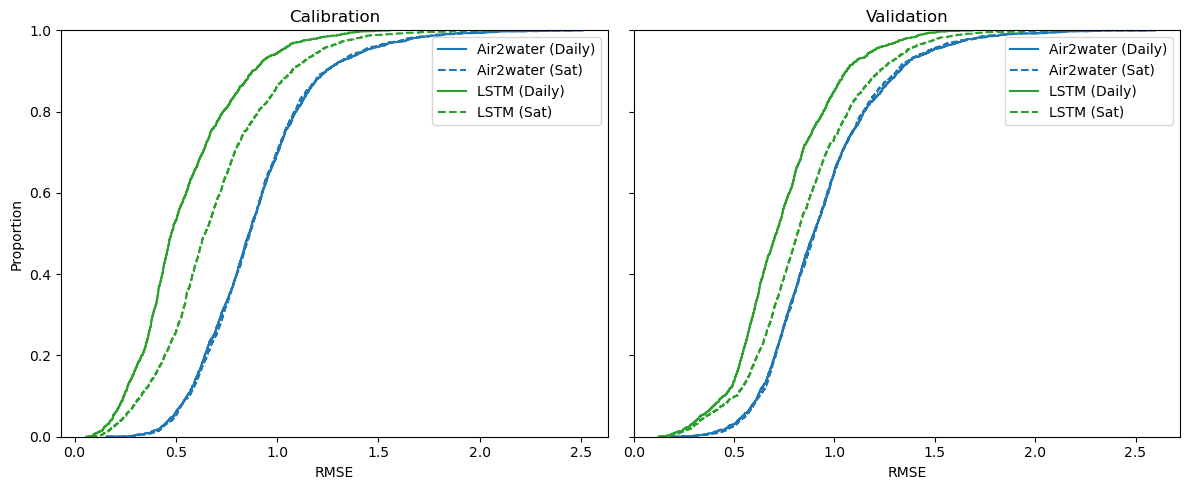

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# First plot: air2water ECDF
sns.ecdfplot(data=a2w_metric_df, x="cal_rmse", label="Air2water (Daily)", ax=axes[0], color = "tab:blue")
sns.ecdfplot(data=a2w_metric_df_cloud, x="cal_rmse", label="Air2water (Sat)", ax=axes[0], color = "tab:blue",  linestyle = "--")
sns.ecdfplot(data=lstm_metric_df, x="cal_rmse", label="LSTM (Daily)", ax=axes[0],color = "tab:green")
sns.ecdfplot(data=lstm_metric_df_cloud, x="cal_rmse", label="LSTM (Sat)", ax=axes[0],color = "tab:green",linestyle = "--")
axes[0].set_xlabel("RMSE")
axes[0].set_title("Calibration")
axes[0].legend()

# Second plot: LSTM ECDF

sns.ecdfplot(data=a2w_metric_df, x="val_rmse", label="Air2water (Daily)", ax=axes[1], color = "tab:blue")
sns.ecdfplot(data=a2w_metric_df_cloud, x="val_rmse", label="Air2water (Sat)", ax=axes[1], color = "tab:blue",  linestyle = "--")
sns.ecdfplot(data=lstm_metric_df, x="val_rmse", label="LSTM (Daily)", ax=axes[1],color = "tab:green")
sns.ecdfplot(data=lstm_metric_df_cloud, x="val_rmse", label="LSTM (Sat)", ax=axes[1] ,color = "tab:green", linestyle = "--")
axes[1].set_xlabel("RMSE")
axes[1].set_title("Validation")
axes[1].legend()

plt.tight_layout()
plt.show()

In [13]:
fig.savefig("../figs/model_performance.png", dpi = 300, bbox_inches='tight')

# Map

In [18]:
import geopandas as gpd

In [19]:
# load cci lakes
cci_lake_list = pd.read_csv("../data/cci_lakes_hydrolake_depth.csv")["CCI ID"].to_numpy()
lakes_with_clz = pd.read_csv("../data/lakes_with_climate_zone.csv", index_col = 0).loc[cci_lake_list]
cci_lakes = pd.read_csv("../data/ESA_CCI_static_lake_mask_v2_1km_UoR_metadata_fv2.1_06Oct2021_4laketemp.csv", index_col=0).loc[cci_lake_list]
cci_lakes = pd.concat([cci_lakes, lakes_with_clz.loc[:,["climate_zone"]]], axis = 1)
cci_lakes_gdf = gpd.GeoDataFrame(cci_lakes, geometry=gpd.points_from_xy(cci_lakes['LON CENTRE'], cci_lakes['LAT CENTRE']),
                                crs="epsg:4326")
cci_lakes_gdf.index.name = "cci_lake_id"

In [20]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

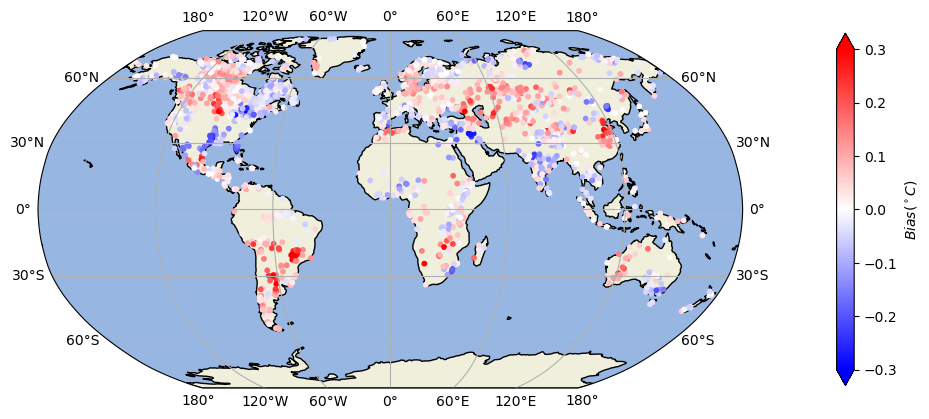

In [27]:
fig = plt.figure(figsize=(10, 5))  # Adjusted the figsize to be wider
nt_proj = ccrs.Robinson()

# change projection
a2w_metric_gdf = gpd.GeoDataFrame(pd.concat([cci_lakes_gdf, a2w_metric_df.astype(float)], axis = 1)).to_crs(nt_proj)
lstm_metric_gdf = gpd.GeoDataFrame(pd.concat([cci_lakes_gdf, lstm_metric_df.astype(float)], axis = 1)).to_crs(nt_proj)

# Geographical distribution of Bias (Left plot)
ax1 = fig.add_subplot(1, 1, 1, projection=nt_proj)
ax1.add_feature(cfeature.OCEAN, zorder=0)
ax1.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
# ax1.set_title("Map of cloud frequency (n = 2016)")
ax1.set_global()
ax1.gridlines(draw_labels=True)

# Plot 
lstm_metric_gdf.plot(column = "val_rmse",
        markersize=10,
        cmap="bwr",
        vmin = -0.3,
        vmax = 0.3,
        legend_kwds={'label': '$RMSE (^\\circ C)$',
                 "orientation": "vertical",
                 "extend": "both",
                 "shrink": 0.75,
                 "pad": 0.1},
        legend = True,
        ax=ax1
        )
# lgd = ax1.get_legend()
# lgd.set_title("Cloud Frequency")
plt.tight_layout()
plt.show()